In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../main/')
from multi_py.multi import *
import numpy as np
import sys  
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.io import readsav
import copy
import pandas as pd
import os
from scipy import integrate
from scipy.signal import argrelextrema
from scipy import interpolate


%config InlineBackend.figure_format='png'
plt.style.use('default')
plt.style.use('../main/multi_py/Bergemann2020.mplstyle')

## Calculate mu angles

In [2]:
mu_zs = [1.0, 0.9, 0.8, 0.6, 0.4, 0.2]
muzout = [1.0]
muxout = [0]
muyout = [0]

for mu_z in mu_zs[1:]:
    conjugate = np.round(np.sqrt(1-mu_z**2),4)
    if mu_z == 0.4:
        conjugate += 0.0001
    for i in range(4):
        muzout.append(mu_z)
    muxout.extend((conjugate, 0.0, -conjugate, 0.0))
    muyout.extend((0.0, conjugate, 0.0, -conjugate))

print('muxout = ',*muxout)
print('muyout = ',*muyout)
print('muzout = ',*muzout)

muxout =  0 0.4359 0.0 -0.4359 0.0 0.6 0.0 -0.6 0.0 0.8 0.0 -0.8 0.0 0.9166 0.0 -0.9166 0.0 0.9798 0.0 -0.9798 0.0
muyout =  0 0.0 0.4359 0.0 -0.4359 0.0 0.6 0.0 -0.6 0.0 0.8 0.0 -0.8 0.0 0.9166 0.0 -0.9166 0.0 0.9798 0.0 -0.9798
muzout =  1.0 0.9 0.9 0.9 0.9 0.8 0.8 0.8 0.8 0.6 0.6 0.6 0.6 0.4 0.4 0.4 0.4 0.2 0.2 0.2 0.2


In [3]:
# muxout = np.fromstring('0.0 0.6092 0.0 -0.6092 0.0 0.7939 0.0 -0.7939 0.0 0.9057 0.0 -0.9057 0.0 0.9804 0.0 -0.9804 0.0', sep=' ')
# muyout = np.fromstring('0.0 0.0 0.6092 0.0 -0.6092 0.0 0.7939 0.0 -0.7939 0.0 0.9057 0.0 -0.9057 0.0 0.9804 0.0 -0.9804', sep=' ')
# muzout = np.fromstring('1.0 0.793 0.793 0.793 0.793 0.608 0.608 0.608 0.608 0.424 0.424 0.424 0.424 0.197 0.197 0.197 0.197', sep=' ')


In [4]:
# for i, _ in enumerate(muxout):
#     dummy = np.sqrt(muxout[i]**2 + muyout[i]**2 + muzout[i]**2)
#     if np.abs(dummy - 1e0) > 1e-4:
#         print('error')
#     print(np.sqrt(muxout[i]**2 + muyout[i]**2 + muzout[i]**2 ) - 1)

## Read in observed spectrum

In [5]:
sav_fname = pjoin('../../data/spectra/1631885174310_iag_sun_Si.sav')
sav_data = readsav(sav_fname)
f = open('../../data/spectra/sun_kpnomu1_6000_8000A.txt')
obs_spec2 = np.loadtxt(fname=f)

In [6]:
# simulation has been run with mus: 1, 0.9, 0.8, 0.6, 0.4, 0.2
# specify the indecies corresponding to these angles in the solar data
sol_mu_ind = [0, 4, 5, 7, 9, 11]
# get the flux(intensity) and wavelengths corresponding to these angles
sol_fluxes = [sav_data['iag_sun'].flux[0][ang] for ang in sol_mu_ind]
sol_lams = [sav_data['iag_sun'].wave[0][ang] for ang in sol_mu_ind]
sol_mus = [sav_data['iag_sun'].mu[0][ang] for ang in sol_mu_ind]

## Read in simulated spectrum

In [7]:
def get_lines(thisrun, krs):
    lines = []
    for kr in krs:
        lines.append(thisrun.line[kr])
    return lines

In [8]:
major_krs = [286, 291, 293, 299, 427] # 292 and 302 removed - empty gaps; 457 removed - does not appear in the ref paper

# runfiles = ['../runs/Si_marcs_LTE_mus/output/', '../runs/Si_stag_NLTE_5x5x230_mus/output/', '../runs/Si_stag_NLTE_10x230_mu_iter/output','../runs/SiStagNLTE_10_f3Dold/output','../runs/Si_stag_NLTE_30_old/output']
runfiles = ['../runs/Si_marcs_LTE_mus/output/', '../runs/SiStagNLTE_30_f3Dold/output/']
# runfiles = ['../runs/iosmet_runs/SiMarcsLTE/output/', '../runs/iosmet_runs/SiStagNLTE30_full3D/output/']


# labels = [ '1D LTE', 'stag5old1.5D', 'stag10old1.5D', 'stag5oldf3D', 'stag30old1.5D']
runobjects = [m3d(thisrun, lines=major_krs, conts=[]) for thisrun in runfiles]
linesobj = [get_lines(thisrunobj, major_krs) for thisrunobj in runobjects]

Completed reading parameters from ../runs/SiStagNLTE_30_f3Dold/output//


In [9]:
wavelengths = [line.lam0 for line in linesobj[0]]
m3d_centre_wavelengths = [5645.613, 5684.484, 5701.104, 5772.146, 7034.901]

In [10]:
def get_ang_intensity(run, kr):
    sim_fluxes = [run.line[kr].i3[:,1]]
    for i, _ in enumerate(sol_mu_ind[1:]):
        ang=i+1
        ang_idx = (ang-1)*4+1
        sim_fluxes.append(np.mean(run.line[kr].i3[:, ang_idx:ang_idx+4], axis=-1))
    return sim_fluxes

## Plot input line profiles

In [11]:
def plot_mu_intensities(line_ind):
    # define the wavelength range for this line with the m3d central wavelenght:
    line_lam = copy.deepcopy(linesobj[0][line_ind].lam)
    line_lam += m3d_centre_wavelengths[line_ind] - linesobj[0][line_ind].lam0

    sim_int_1d = get_ang_intensity(runobjects[0], kr=major_krs[line_ind])
    sim_int_1d_norm = sim_int_1d/continuum(line_lam, np.array(sim_int_1d))
    sim_int_3d = get_ang_intensity(runobjects[1], kr=major_krs[line_ind])
    sim_int_3d_norm = sim_int_3d/continuum(line_lam, np.array(sim_int_3d))

    fig, ax = plt.subplots(len(sol_mu_ind), 1, figsize=(17,25))

    for i, mu in enumerate(sol_mu_ind):
        # plot 1D LTE with cmacroturbulence onvolution Vmac = 3km
        ax[i].plot(line_lam, sim_int_1d_norm[i], label=f'1D LTE')
        ax[i].plot(*convol(line_lam, sim_int_1d_norm[i], zeta_rt=3), label=f'1D LTE conv')

        ax[i].plot(line_lam, sim_int_3d_norm[i], label=f'3D NLTE') 

        
        ax[i].plot(sol_lams[i], sol_fluxes[i], linestyle='none', marker='.', zorder=100, label=f'IAG solar spec')

        
        plt.sca(ax[i])
        plt.title(f'Line = {m3d_centre_wavelengths[line_ind]}, mu = {sol_mus[i]:.2f}')
        plt.xlim((m3d_centre_wavelengths[line_ind]-0.35), (m3d_centre_wavelengths[line_ind]+0.35))
        plt.ylim(0.35,1.05)
        plt.ylabel('Normalised Intensity')
        plt.xlabel('λ (Å)')
        plt.legend()
#     fig.savefig('../plots/kr5645_1.5D.pdf')

In [12]:
# def plot_mu_intensities(line_ind):
#     # define the wavelength range for this line with the m3d central wavelenght:
#     line_lam = copy.deepcopy(linesobj[0][line_ind].lam)
#     line_lam += m3d_centre_wavelengths[line_ind] - linesobj[0][line_ind].lam0


#     # get the resolved intensities for the simulated spectra
#     sim_ints_norm_list = []
#     for i,run in enumerate(runobjects):
#         sim_int = get_ang_intensity(runobjects[i], kr=major_krs[line_ind])
#         sim_ints_norm = sim_int/continuum(line_lam, np.array(sim_int))
#         sim_ints_norm_list.append(sim_ints_norm)


#     # sim_int_1d = get_ang_intensity(runobjects[0], kr=major_krs[line_ind])
#     # sim_int_1d_norm = sim_int_1d/continuum(line_lam, np.array(sim_int_1d))
#     # sim_int_3d = get_ang_intensity(runobjects[1], kr=major_krs[line_ind])
#     # sim_int_3d_norm = sim_int_3d/continuum(line_lam, np.array(sim_int_3d))

#     fig, ax = plt.subplots(len(sol_mu_ind), 1, figsize=(17,25))

#     for i, mu in enumerate(sol_mu_ind):
#         for j, run in enumerate(sim_ints_norm_list):
#             ax[i].plot(line_lam, sim_ints_norm_list[j][i], label=labels[j])
#             if j==0:
#             # plot 1D LTE with cmacroturbulence onvolution Vmac = 3km
#              ax[i].plot(*convol(line_lam, sim_ints_norm_list[j][i], zeta_rt=3), label=f'1D LTE conv')


        
#         ax[i].plot(sol_lams[i], sol_fluxes[i], linestyle='none', marker='.', zorder=100, label=f'IAG solar spec')

        
#         plt.sca(ax[i])
#         plt.title(f'Line = {m3d_centre_wavelengths[line_ind]}, mu = {sol_mus[i]:.2f}')
#         plt.xlim((m3d_centre_wavelengths[line_ind]-0.35), (m3d_centre_wavelengths[line_ind]+0.35))
#         plt.ylim(0.35,1.05)
#         plt.ylabel('Normalised Intensity')
#         plt.xlabel('λ (Å)')
#         plt.legend()
#     # fig.savefig('line1_mudep.pdf')

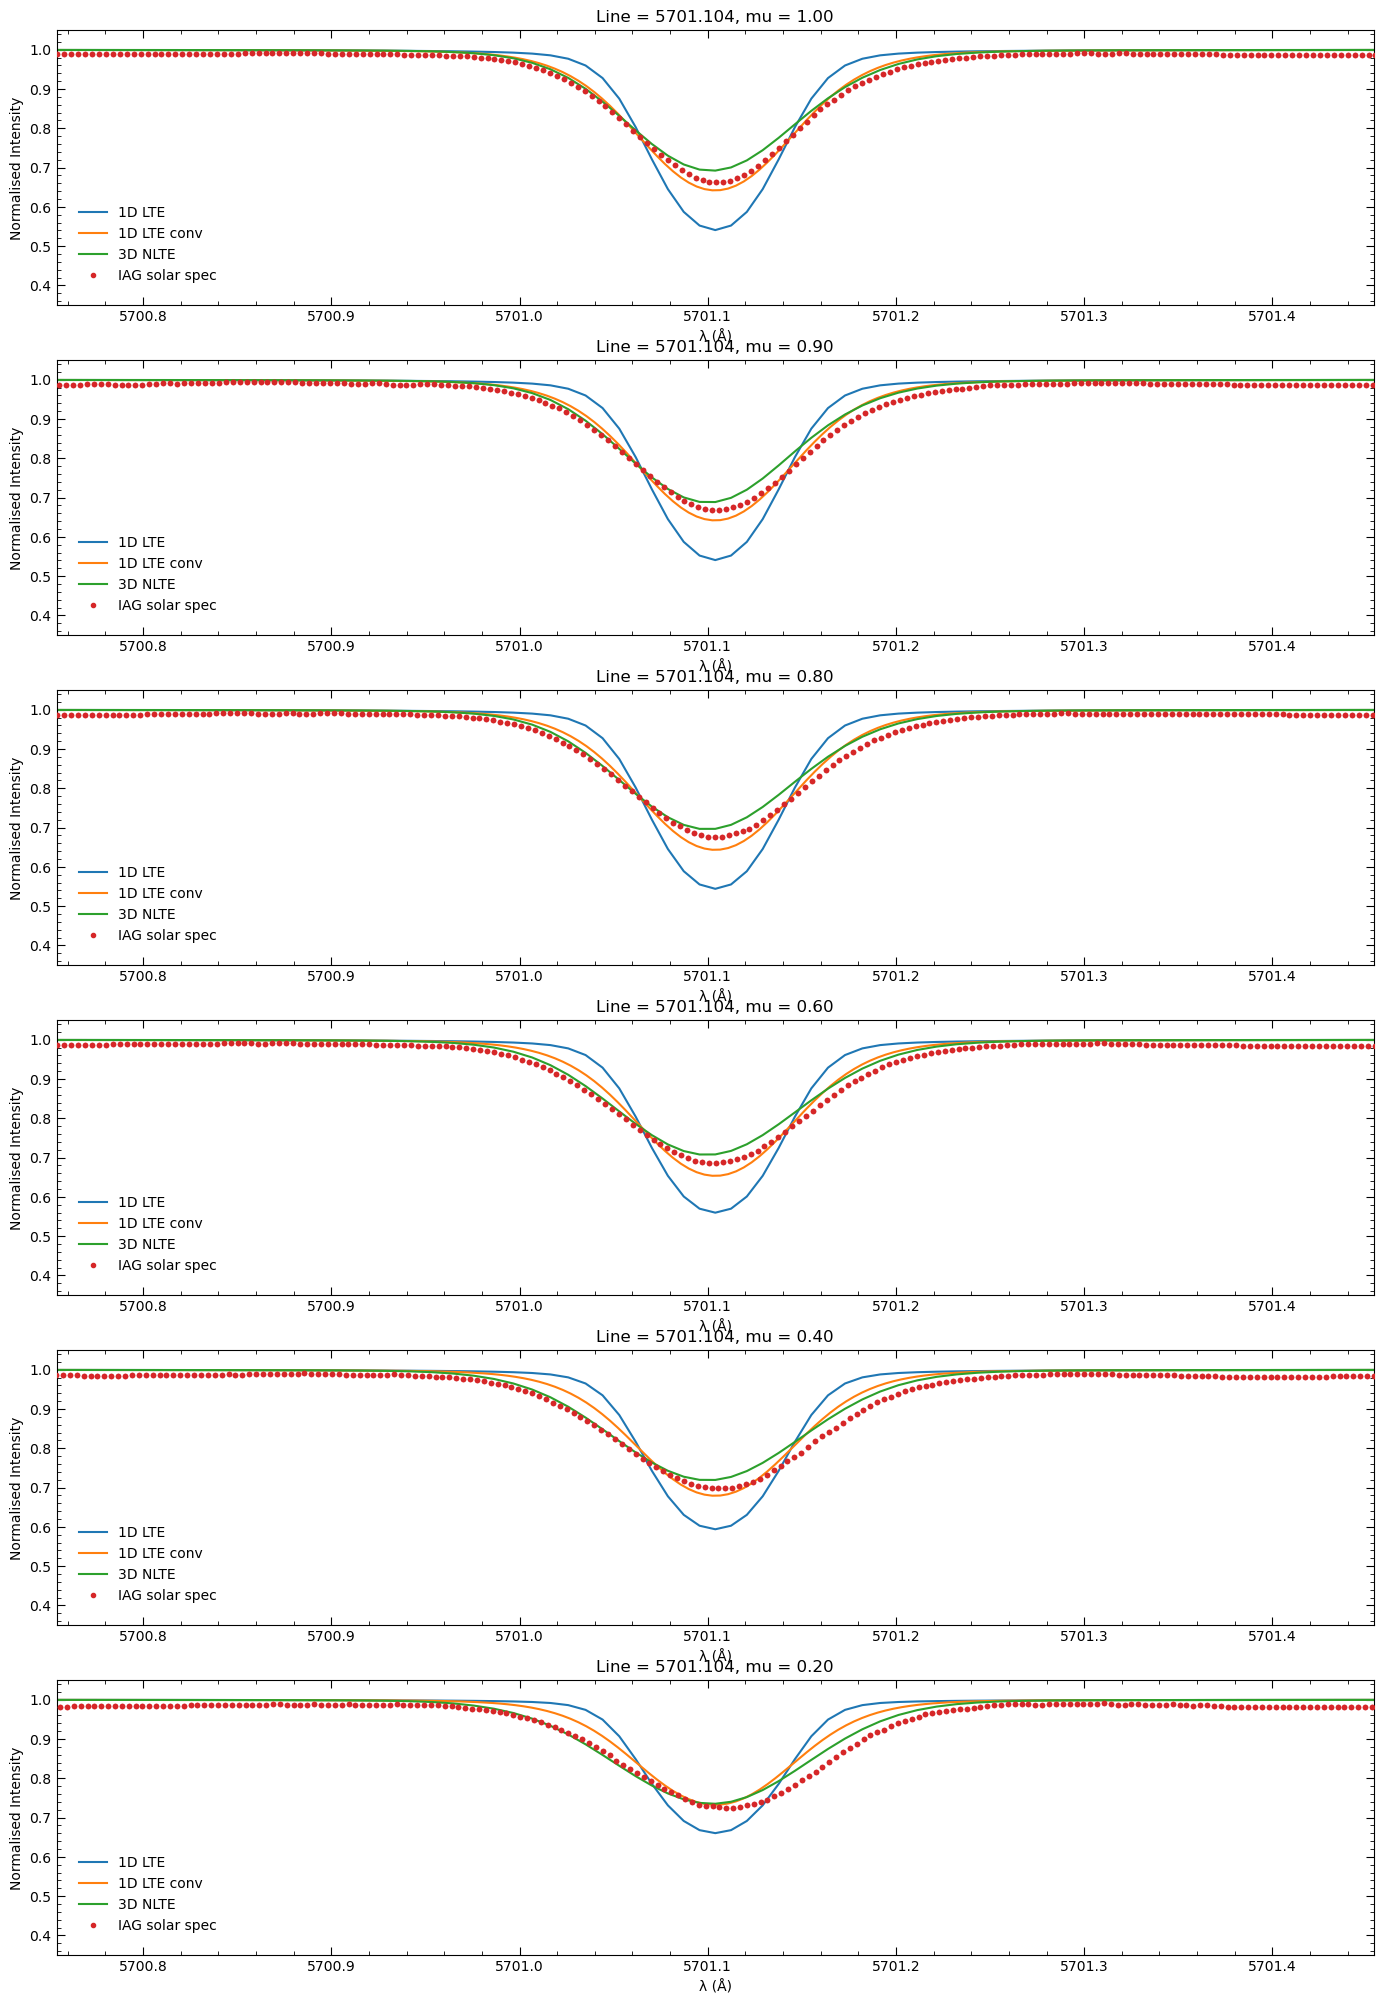

In [13]:
plot_mu_intensities(2)

## Calculate EWs for the observed spectra

In [14]:
# define the integration limits for the iag observed solar spectrum for each line (keep same across angles)
iag_int_lims = np.array([[5645.4, 5645.8],[5684.31,5684.7],[5700.97,5701.3],[5771.9,5772.35],[7034.55,7035.2]])

In [15]:
eq_iag = np.zeros((len(major_krs), len(sol_mu_ind)))
sol_lam_range_list = np.zeros((len(major_krs), len(sol_mu_ind)), dtype=object)
sol_int_range_list = np.zeros((len(major_krs), len(sol_mu_ind)), dtype=object)
for i, line in enumerate(major_krs):
    line_lammin, line_lammax = iag_int_lims[i]
    for j, mu in enumerate(sol_mu_ind):
        lam_range = sol_lams[j][np.logical_and((sol_lams[j] > line_lammin), (sol_lams[j] < line_lammax))]
        intensity_range = sol_fluxes[j][np.logical_and((sol_lams[j] > line_lammin), (sol_lams[j] < line_lammax))]
        eq_iag[i,j] = integrate.simps(y=1-intensity_range, x=lam_range) * 1000
        # record the wavelengths and intensities corresponding to each line
        sol_lam_range_list[i,j] = lam_range
        sol_int_range_list[i,j] = intensity_range

## Read in CoG simulated spectra and calculate EWs

In [16]:
LTE_runs = '../runs/Si_marcs_LTE_dir/'
# LTE_runs = '../runs/iosmet_runs/SiMarcsLTEdir/'

LTE1d_cog = CoG(runs=LTE_runs, lines=major_krs)

Completed reading parameters from ../runs/Si_marcs_LTE_dir//7.76//output//


In [17]:
def get_cog_eqw(cogobj, kr, qmax):
    all_eqws =  [cogobj.calc_weq(kr=kr, qmax=qmax, ang=ang, norm=True) for ang in range((4*len(sol_mus[1:])+1))]
    # print(all_eqws)
    kr_eqws = [all_eqws[0]]
    # print(kr_eqws)
    for mu, _ in enumerate(sol_mus[1:]):
        ang_start = mu*4+1
        ang_end = ang_start+4
        kr_eqws.append(np.mean(all_eqws[ang_start:ang_end], axis=0))
        # print(f'{ang_start}:{ang_end}')
        # print(f'range-{all_eqws[ang_start]}:{all_eqws[ang_end-1]}')
    return kr_eqws

In [18]:
# eqwidths_1dlte = np.array([[test_cog.calc_weq(kr=kr, ang=ang, qmax=3.5, norm=True) for ang in range(len(mu_zs))] for kr in major_krs])
eqwidths_1dlte = np.array([get_cog_eqw(cogobj=LTE1d_cog, kr=thiskr, qmax=3.5) for thiskr in major_krs])


## Plot EWs vs mu angles for CoG 1D LTE, 3D NLTE and observed spectra


In [50]:
# read in 3D NLTE EWs

# eq_3DNLTE = np.load('../mdata/3DNLTE_eqs_30f3Diosmet.npy')
eq_3DNLTE = np.load('../mdata/3DNLTE_eqs_30f3D_noiosmet_5wl.npy')

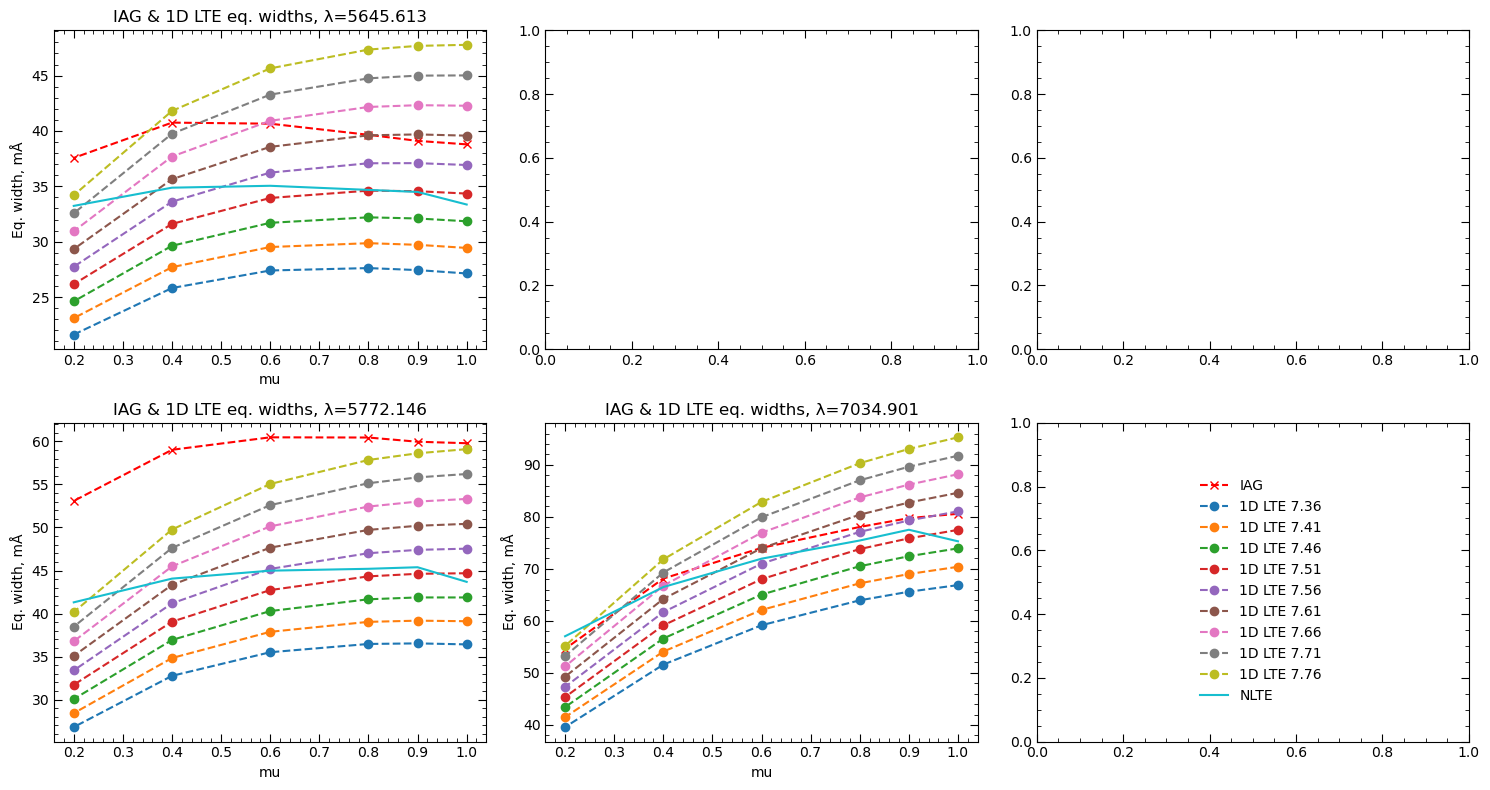

In [51]:
fig, axs = plt.subplots(2,3, figsize=(15,8),squeeze=True)

# for i, run in enumerate(ex_1d_eqw):
#     axs[1,1].plot(sol_mus, ex_1d_eqw[:,i], '--o', label=round(test_cog.abnds[i],2))
count = 0
for col, ax in zip(range(len(major_krs)), axs.flatten()):

    # ax.plot(sol_mus, eq_iag[col],'r--x', label='IAG')
    # ax.set_xlabel('mu')
    # ax.set_ylabel('Eq. width, mÅ')
    # ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
    # for i, run in enumerate(LTE1d_cog.abnds):
    #     ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

    # plot the 3D NLTE EWs
    
    if col==0 or col==3 or col==4:


        ax.plot(sol_mus, eq_iag[col],'r--x', label='IAG')
        ax.set_xlabel('mu')
        ax.set_ylabel('Eq. width, mÅ')
        ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
        for i, run in enumerate(LTE1d_cog.abnds):
            ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

        # plot the 3D NLTE EWs
        ax.plot(sol_mus, eq_3DNLTE[count], label='NLTE')


        count +=1
    if col==4:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc=(0.8,0.1))


plt.tight_layout()
# plt.savefig('../plots/EWs_mus_IOSMET_withNLTE.pdf')

## Plot zoomed-out observed spectra 

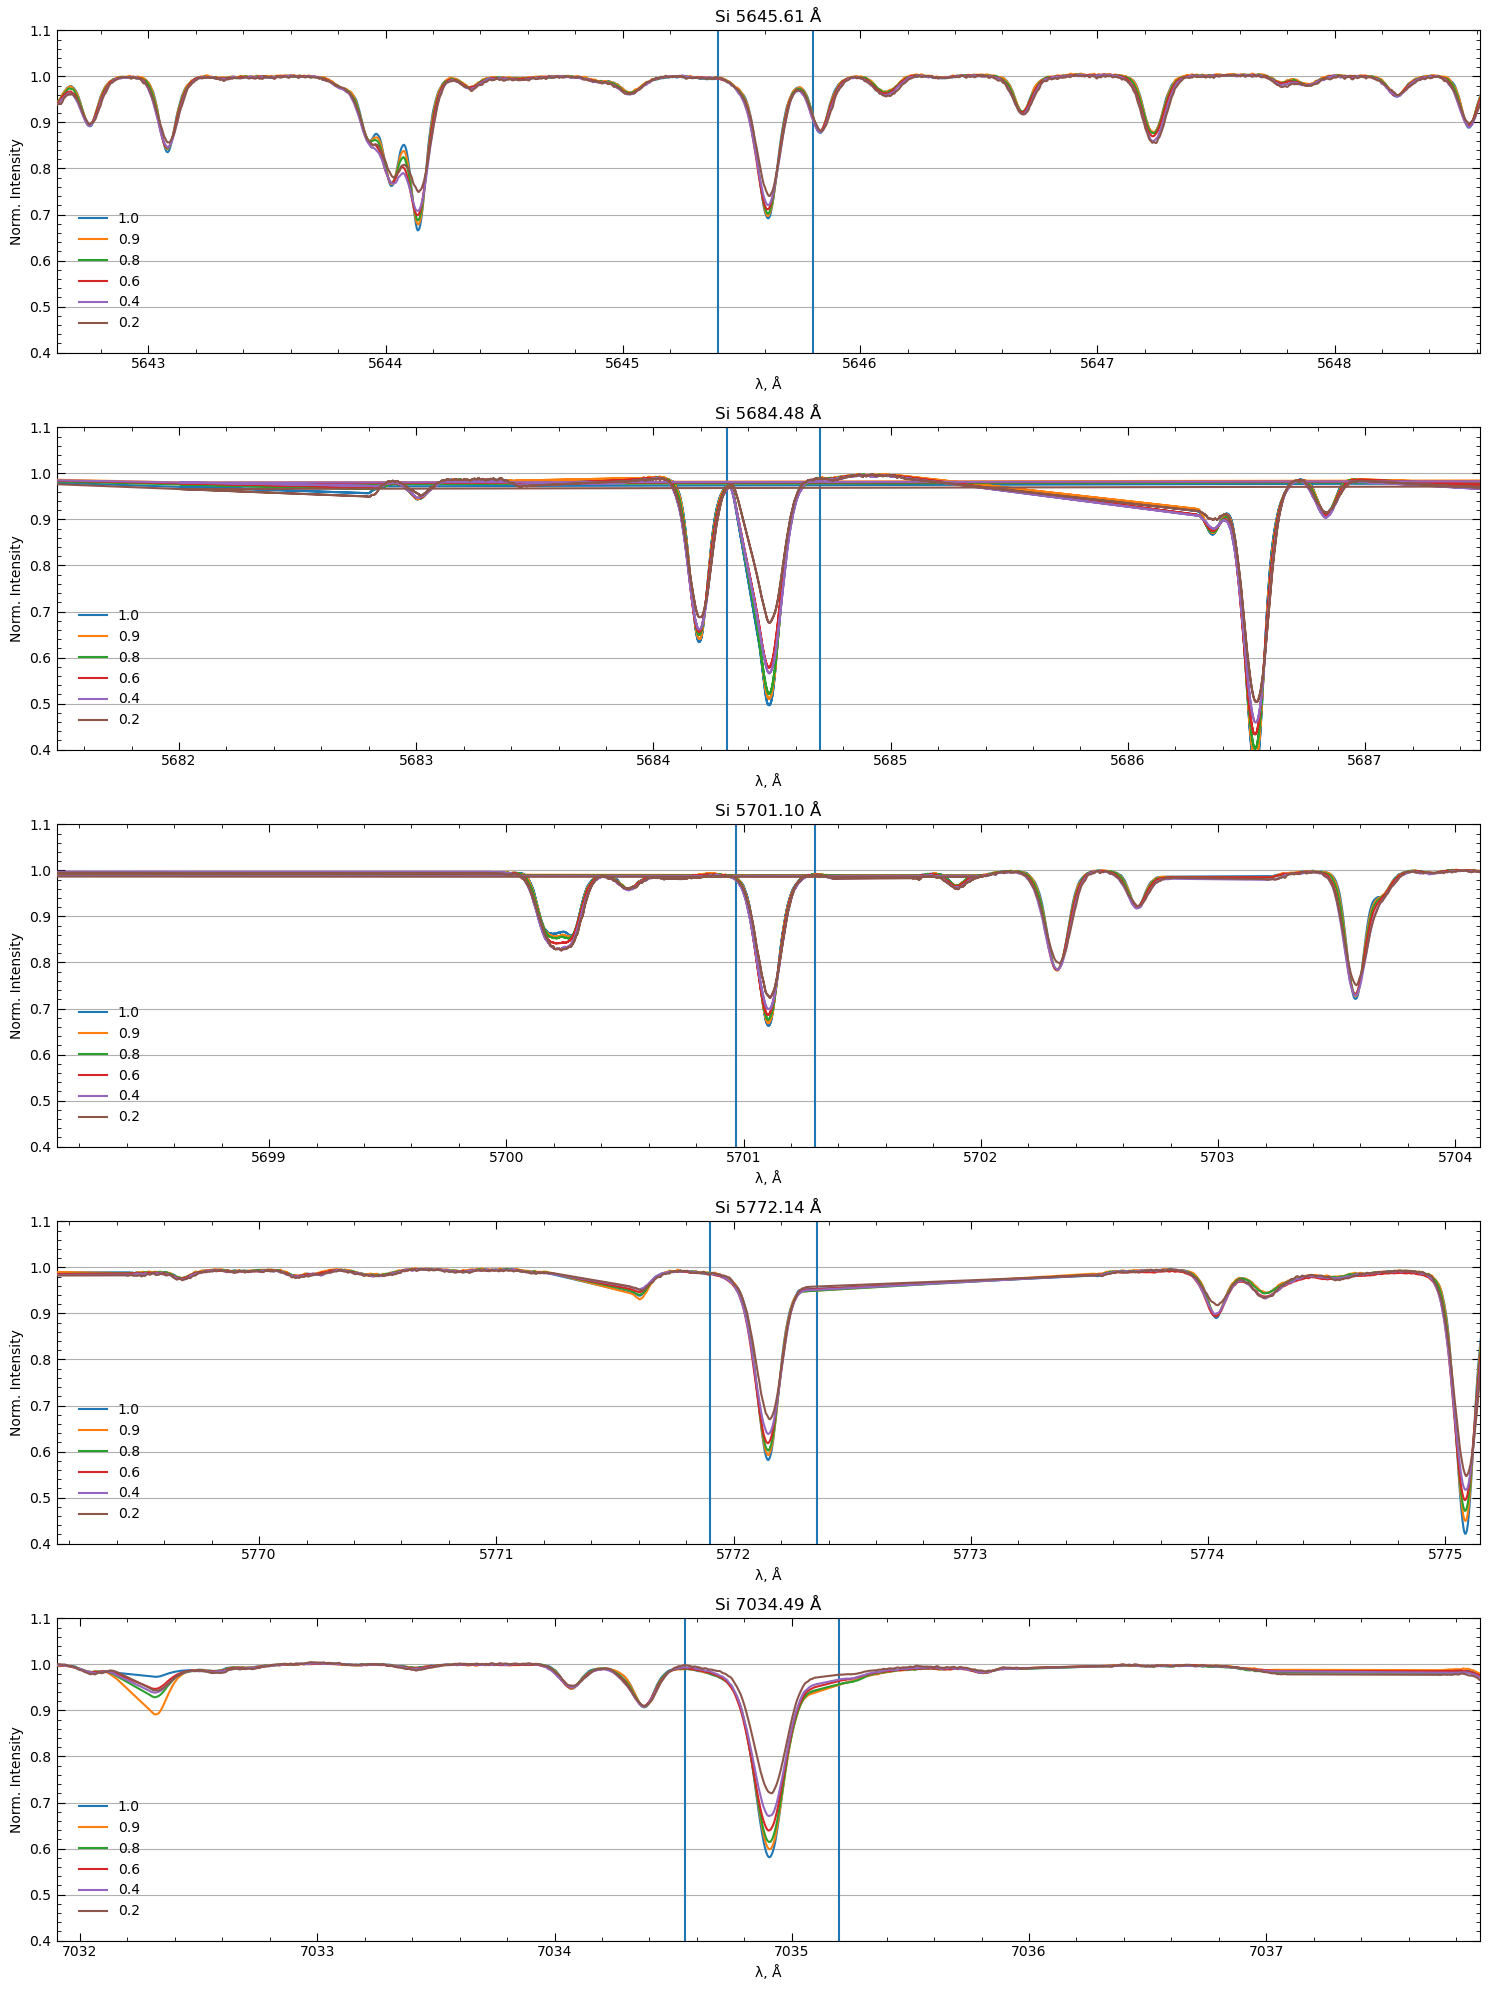

In [52]:
fig, ax = plt.subplots(len(major_krs), 1, figsize=(15,20))

for i, thiskr in enumerate(major_krs):
    
    for j, thismu in enumerate(sol_mus):
        # plt.sca(ax[j])
        ax[i].plot(sol_lams[j], sol_fluxes[j], zorder=100, label=sol_mus[j])#,markersize=4)


    # plot picked integration limits 
    for lim in iag_int_lims[i,:]:
        ax[i].axvline(lim)
    ax[i].grid(axis='y')

    ax[i].set_title(f'Si {wavelengths[i]:.2f} Å')
    ax[i].set_ylabel('Norm. Intensity')
    ax[i].set_xlabel('λ, Å')

    plt.sca(ax[i])

    plt.xlim((m3d_centre_wavelengths[i]-3), (m3d_centre_wavelengths[i]+3))
    plt.ylim(0.4,1.1)    
    ax[i].legend()

plt.tight_layout()

## Deblending, renormalising lines in observed spectra

In [53]:
from scipy.signal import argrelextrema
from scipy.special import voigt_profile
from scipy import optimize

def synth_blends(obs_xx, obs_yy, order=20, blank_lam=None):
    exts = np.array(argrelextrema(obs_yy, np.less, order=order))[0]
    
    pn=5
    def model_func(xdata, *args):
        yy_pred = np.ones_like(xdata)
        
        for i, gamma in enumerate(args[::pn]):
            sigma = args[1::pn][i]
            scale = args[2::pn][i]
            shift = args[3::pn][i]
            skew  = args[4::pn][i]
            ext = exts[i]
            
            sxx = xdata - xdata[ext] + shift
            voigt = voigt_profile(sxx, sigma, gamma)
            
            sk_xx = sxx+np.abs(sxx)*skew
            sk_voigt = np.interp(sxx, sk_xx, voigt)
            
            yy_pred -= sk_voigt / np.max(sk_voigt) * (1-obs_yy[ext]) * scale
            
        return yy_pred
    
    params = np.ones(exts.size*pn)*1e-2
    params[2::pn] = 1
    params[3::pn] = 0
    params[4::pn] = 0
    
    pfit, pcov = optimize.curve_fit(model_func, obs_xx, obs_yy, p0=params)
    
    if blank_lam is not None:
        pfit_blank = pfit.copy()
        iline = np.where(obs_xx[exts] > blank_lam)[0][0]
        pfit_blank[pn*iline+2] = 0
        
        yy = model_func(obs_xx, *pfit_blank)
        
    else:
        yy = model_func(obs_xx, pfit)
    
    return yy

In [54]:
line_0_eqw = []
line_0_int = []
for j, mu in enumerate(sol_mus):
    xx = sol_lams[j]
    yy = sol_fluxes[j]
    lam0 = m3d_centre_wavelengths[0]
    mask = np.abs(xx - lam0) < 0.4
    xx = xx[mask]
    yy = yy[mask]
    

    thislam0 = xx[np.argmin(yy)]
    yy_blend = synth_blends(xx, yy, order=25, blank_lam=0)
    # yy_blend = synth_blends(xx, yy, order=20, blank_lam=lam0)
    yy_deblend = 1 - ((1-yy) - (1-yy_blend))

    line_0_eqw.append(integrate.simps(y=1-yy_deblend, x=xx) * 1000)
    line_0_int.append(yy_deblend)

    # overwrite lambda/int range for this line 
    sol_lam_range_list[0,j] = xx
    sol_int_range_list[0,j] = yy_deblend

In [55]:
# sim_int_1d = get_ang_intensity(runobjects[0], kr=major_krs[line_ind])
# sim_int_1d_norm = sim_int_1d/continuum(line_lam, np.array(sim_int_1d))

# define continuum at the chosen integration limits for each line
# renorm_lines_indx = [3,4]
sol_int_renorm = np.zeros((len(major_krs), len(sol_mu_ind)), dtype=object)

for i, line in enumerate(major_krs):
    for j, mu in enumerate(sol_mus):
        sol_int_renorm[i,j] = sol_int_range_list[i,j]/continuum(sol_lam_range_list[i,j], sol_int_range_list[i,j])

In [56]:
# replot with new normalisation
plot=False
if plot==True:
    fig, ax = plt.subplots(len(major_krs), 1, figsize=(13,20))

    for i, line_i in enumerate(major_krs):
        
        for j, thismu in enumerate(sol_mus):
            # plt.sca(ax[j])
            ax[i].plot(sol_lam_range_list[i,j], sol_int_renorm[i,j], zorder=100, label=sol_mus[j],markersize=4)
            # ax[i].plot(sol_lam_range_list[i,j], sol_int_range_list[i,j], linestyle='none', marker='.', zorder=100, label=sol_mus[j],markersize=4)


        # plot picked integration limits 
        for lim in iag_int_lims[i,:]:
            ax[i].axvline(lim)
        ax[i].grid(axis='y')

        ax[i].set_title(f'Si {wavelengths[i]:.2f} Å')
        ax[i].set_ylabel('Norm. Intensity')
        ax[i].set_xlabel('λ, Å')

        plt.sca(ax[i])

        plt.xlim((m3d_centre_wavelengths[i]-0.25), (m3d_centre_wavelengths[i]+0.25))
        plt.ylim(0.4,1.1)    
        ax[i].legend()

    plt.tight_layout()

## Plot EWs after observed spectra processing

In [57]:
# Replot the equivalent widths
# recalculate equivalent widths
new_eq_iag = np.zeros(eq_iag.shape)
for i, line_i in enumerate(major_krs):
    for j, thismu in enumerate(sol_mus):
            new_eq_iag[i,j] = integrate.simps(y=1-sol_int_renorm[i,j], x=sol_lam_range_list[i,j]) * 1000


# fig, axs = plt.subplots(2,3, figsize=(15,10),squeeze=True)

# # for i, run in enumerate(ex_1d_eqw):
# #     axs[1,1].plot(sol_mus, ex_1d_eqw[:,i], '--o', label=round(test_cog.abnds[i],2))

# for col, ax in zip(range(len(major_krs)), axs.flatten()):

#     ax.plot(sol_mus, new_eq_iag[col],'r--x', label='IAG')
#     ax.set_xlabel('mu')
#     ax.set_ylabel('Eq. width, mÅ')
#     ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
#     for i, run in enumerate(LTE1d_cog.abnds):
#         ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=round(LTE1d_cog.abnds[i],2))
#     ax.legend()


# plt.tight_layout()
# # plt.savefig('plots/IAG_ewq.pdf')

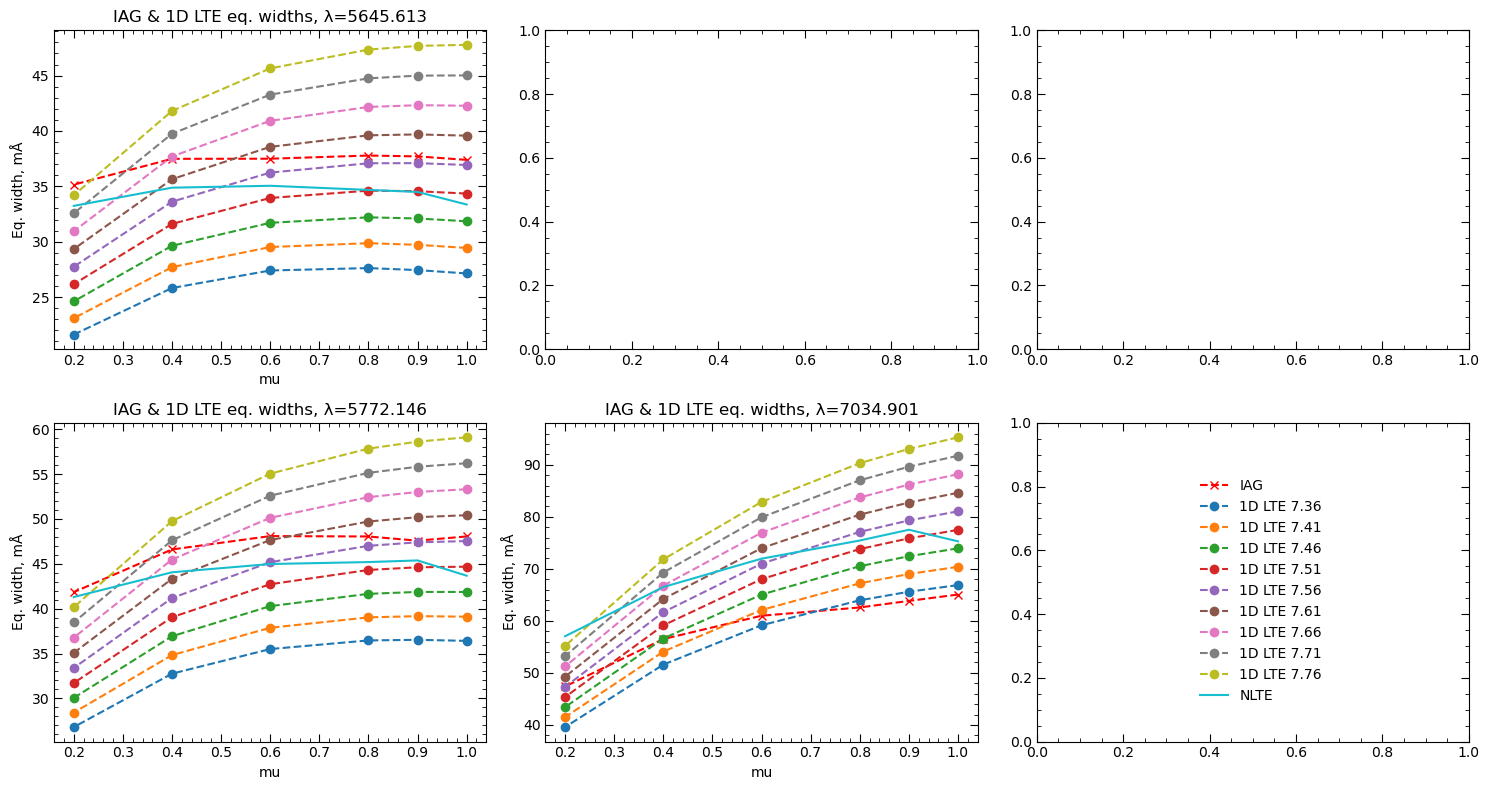

In [58]:
fig, axs = plt.subplots(2,3, figsize=(15,8),squeeze=True)

# for i, run in enumerate(ex_1d_eqw):
#     axs[1,1].plot(sol_mus, ex_1d_eqw[:,i], '--o', label=round(test_cog.abnds[i],2))
count = 0
for col, ax in zip(range(len(major_krs)), axs.flatten()):

    # ax.plot(sol_mus, eq_iag[col],'r--x', label='IAG')
    # ax.set_xlabel('mu')
    # ax.set_ylabel('Eq. width, mÅ')
    # ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
    # for i, run in enumerate(LTE1d_cog.abnds):
    #     ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

    # plot the 3D NLTE EWs
    
    if col==0 or col==3 or col==4:


        ax.plot(sol_mus, new_eq_iag[col],'r--x', label='IAG')
        ax.set_xlabel('mu')
        ax.set_ylabel('Eq. width, mÅ')
        ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
        for i, run in enumerate(LTE1d_cog.abnds):
            ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

        # plot the 3D NLTE EWs
        ax.plot(sol_mus, eq_3DNLTE[count], label='NLTE')


        count +=1
    if col==4:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc=(0.8,0.1))


plt.tight_layout()
# plt.savefig('../plots/EWs_mus_IOSMET_withNLTE_renormed.pdf')

In [59]:
eq_3DNLTE.shape

(5, 6)

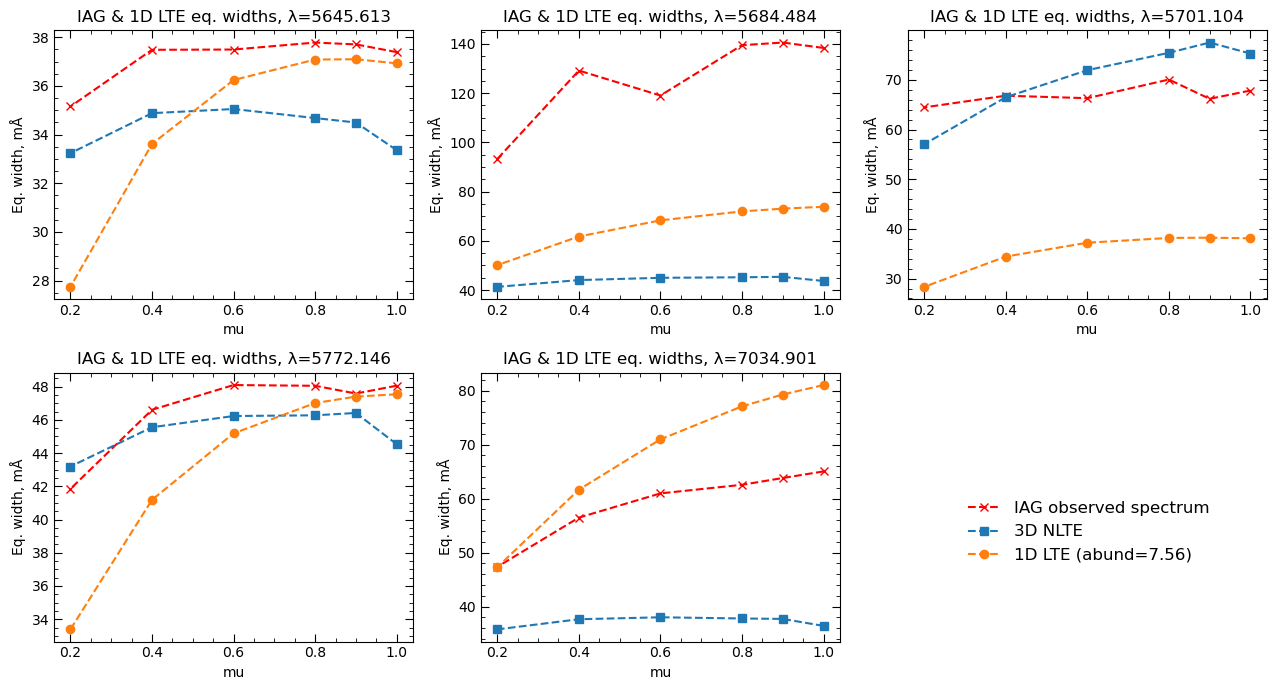

In [86]:
# M: make EWs vs mu plot with only one 1D LTE line
fig=plt.figure(figsize=(13,7))
for i in range(1, 6):
    fig.add_subplot(2, 3, i)
    # plot observed spectra EWs
    plt.plot(sol_mus, new_eq_iag[i-1],'r--x', label='IAG observed spectrum')
    # plot the 3D NLTE EWs
    plt.plot(sol_mus, eq_3DNLTE[i-1], '--s', label='3D NLTE')
    # plot 1D LTE EWs for abund=7.56
    central_abund_ind=4
    plt.plot(sol_mus, eqwidths_1dlte[i-1,:,central_abund_ind], '--o', label=f'1D LTE (abund={round(LTE1d_cog.abnds[central_abund_ind],2)})')

    
    plt.xlabel('mu')
    plt.ylabel('Eq. width, mÅ')
    plt.title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[i-1]}')
    # if i==5:
        # handles, labels = ax.get_legend_handles_labels()
        # fig.legend(handles, labels, loc=(0.8,0.1))
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75,0.17), fontsize='large')

plt.tight_layout()
# plt.savefig('../plots/EWs_renorm_3lines.pdf')

## Interpolate abundances for observed spectra

In [28]:
def interp_abund(lte1d_lines_eq, lte1d_abundances, iag_eq):
    interpd_sol_abunds = np.zeros((len(lte1d_lines_eq), len(sol_mus)), dtype=object)
    for i, line_eq in enumerate(lte1d_lines_eq):
        for j, mu in enumerate(sol_mus):
            x = lte1d_lines_eq[i,j,:]
            y = lte1d_abundances
            f = interpolate.interp1d(x,y,fill_value='extrapolate')

            interpd_sol_abunds[i,j] = f(iag_eq[i,j])
    return interpd_sol_abunds

In [29]:
iag_1dlte_abunds = interp_abund(np.take(eqwidths_1dlte, [0,3,4], axis=0), LTE1d_cog.abnds, np.take(new_eq_iag, [0,3,4], axis=0))
iag_1dlte_abunds

array([[array(7.5687147), array(7.57175371), array(7.5738413),
        array(7.58695404), array(7.65488745), array(7.78936987)],
       [array(7.56892816), array(7.56332892), array(7.57916491),
        array(7.61885117), array(7.68627473), array(7.80904179)],
       [array(7.33421178), array(7.33404869), array(7.3389663),
        array(7.39108047), array(7.4578495), array(7.56186874)]],
      dtype=object)

In [30]:
# NLTE3Dcorrections = np.load('../mdata/3DNLTE_abund_corr_old30_newang.npy')
NLTE3Dcorrections = np.load('../mdata/3DNLTE_abund_corr_30_newang_iosmet.npy')


In [31]:
NLTE3Dcorrections.reshape(3,6)

array([[-0.06505299, -0.09559547, -0.10421095, -0.14841923, -0.24633543,
        -0.47730107],
       [-0.07428511, -0.12141987, -0.13040867, -0.18477593, -0.30236804,
        -0.57140655],
       [-0.02883711, -0.0929749 , -0.09653142, -0.1499994 , -0.24763691,
        -0.43449183]])

In [32]:
iag_3DNLTE_corrected_abund = np.add(iag_1dlte_abunds, NLTE3Dcorrections.reshape(3,6))

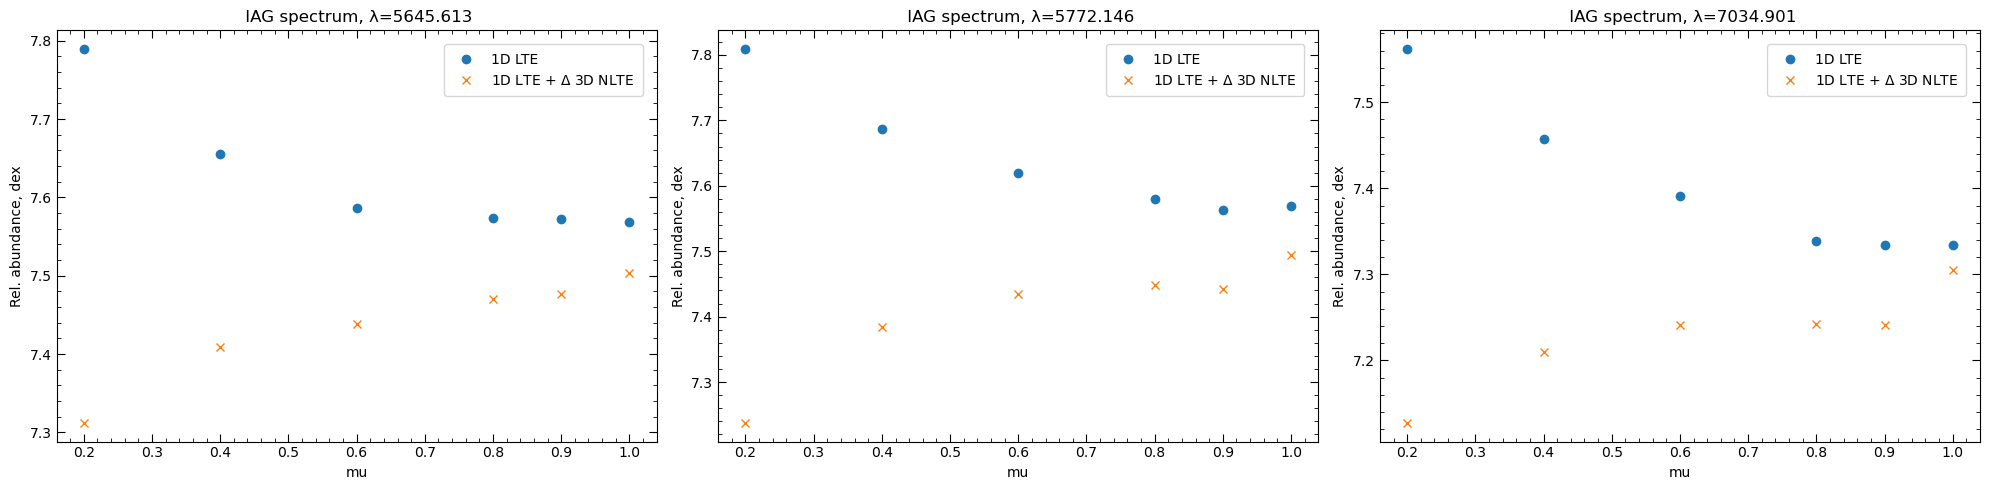

In [33]:
fig, ax = plt.subplots(1,len(iag_1dlte_abunds), figsize=(20,5))

for i, line in enumerate(iag_1dlte_abunds):
    ax[i].plot(sol_mus, iag_1dlte_abunds[i], 'o', label='1D LTE')
    ax[i].plot(sol_mus, iag_3DNLTE_corrected_abund[i], 'x', label='1D LTE + $\Delta$ 3D NLTE')

    ax[i].set_xlabel('mu')
    ax[i].set_ylabel('Rel. abundance, dex')
    ax[i].set_title(f' IAG spectrum, λ={np.take(m3d_centre_wavelengths,[0,3,4])[i]}')
    # ax[i].set_ylim(7.46, 7.65)
    ax[i].legend(frameon=1)
plt.tight_layout()
# fig.savefig('../plots/iag_3dnlte_abund_corr30IOSMETf3D.pdf')